# Full Forex EURUSD environment price movement prediction

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(""), os.pardir)))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
from lightgbm import LGBMClassifier, plot_importance
from sklearn import model_selection, metrics
from statsmodels.graphics.tsaplots import plot_pacf
from rl_trading.data import (
    FOREX_PAIRS,
    ForexDataSource,
    ForexFeEngStrategy,
    load_processed_forex_data,
    preprocess_forex_data,
    engineer_forex_features,
    train_val_eval_split
)
from rl_trading.environments import (
    Actions,
    ForexEnvBasic,
    ForexMarketOrderStrategyFixed,
    ForexMarketOrderStrategyAllIn,
    ForexRewardStrategyLogPortfolioReturn,
    ForexRewardStrategyWeightedLogPortfolioReturns,
    ForexTradingCostsStrategySpread,
    TrnOrEvalForexWrapper,
    RandomEpisodeForexWrapper
)
from config import DATA_PATH

In [3]:
RANDOM_SEED = 604

In [4]:
TARGET = 'EURUSD'

In [5]:
EVAL_END_DATE = datetime(2022,9,30,18,45,0)
EVAL_START_DATE = EVAL_END_DATE - timedelta(hours=25000)
VAL_START_DATE = EVAL_START_DATE - timedelta(hours=25000)
TRN_START_DATE = datetime(2003,1,2,1,0,0)

In [6]:
forex_data = load_processed_forex_data(DATA_PATH, ForexDataSource.FOREXTESTER, pairs=FOREX_PAIRS, version='Agg')

In [7]:
basic_features = engineer_forex_features(forex_data, ForexFeEngStrategy.BASIC, {'recent_returns' : 8})

basic_features_trn, basic_features_val, basic_features_eval = train_val_eval_split(
    basic_features,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

In [8]:
ta_target_features = engineer_forex_features({TARGET : forex_data[TARGET]}, ForexFeEngStrategy.TA, {'lags' : 8})

ta_target_features_trn, ta_target_features_val, ta_target_features_eval = train_val_eval_split(
    ta_target_features,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:748: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._dip[0] = pos.dropna()[0: self._window].sum()
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:760: FutureWarning: The behavior of `series[i:j]` with 

In [9]:
extended_features_trn = pd.merge(basic_features_trn, ta_target_features_trn, on='<DT>')
extended_features_val = pd.merge(basic_features_val, ta_target_features_val, on='<DT>')
extended_features_eval = pd.merge(basic_features_eval, ta_target_features_eval, on='<DT>')

In [10]:
target_prices = forex_data[TARGET]

target_prices['<PRICE DIR>'] = (target_prices['<OPEN>'] <= target_prices['<CLOSE>']).astype('uint8')

target_prices_trn, target_prices_val, target_prices_eval = train_val_eval_split(
    target_prices,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

target_price_dir_trn = target_prices_trn['<PRICE DIR>']
target_price_dir_val = target_prices_val['<PRICE DIR>']
target_price_dir_eval = target_prices_eval['<PRICE DIR>']

In [11]:
len(extended_features_trn), len(extended_features_val), len(extended_features_eval)

(492327, 100000, 100000)

In [12]:
lgbm_class = LGBMClassifier(num_leaves=1000, max_depth=20, learning_rate=0.05, n_estimators=150, colsample_bytree=0.7)

In [13]:
lgbm_class.fit(
    X=extended_features_trn.drop('<DT>', axis=1), 
    y=target_price_dir_trn,
    eval_set=[(extended_features_val.drop('<DT>', axis=1), target_price_dir_val)],
    verbose=True
)

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.601438
[2]	valid_0's binary_logloss: 0.593096
[3]	valid_0's binary_logloss: 0.585437
[4]	valid_0's binary_logloss: 0.578552
[5]	valid_0's binary_logloss: 0.571973
[6]	valid_0's binary_logloss: 0.56596
[7]	valid_0's binary_logloss: 0.560317
[8]	valid_0's binary_logloss: 0.555123
[9]	valid_0's binary_logloss: 0.550324
[10]	valid_0's binary_logloss: 0.545923
[11]	valid_0's binary_logloss: 0.541744
[12]	valid_0's binary_logloss: 0.537813
[13]	valid_0's binary_logloss: 0.534212
[14]	valid_0's binary_logloss: 0.530868
[15]	valid_0's binary_logloss: 0.527672
[16]	valid_0's binary_logloss: 0.524753
[17]	valid_0's binary_logloss: 0.522054
[18]	valid_0's binary_logloss: 0.519474
[19]	valid_0's binary_logloss: 0.516998
[20]	valid_0's binary_logloss: 0.514707
[21]	valid_0's binary_logloss: 0.512541
[22]	valid_0's binary_logloss: 0.510503
[23]	valid_0's binary_logloss: 0.5086
[24]	valid_0's binary_logloss: 0.506838
[25]	valid_0's binary_logloss: 0.505193
[26]	valid_0

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=20,
               n_estimators=150, num_leaves=1000)

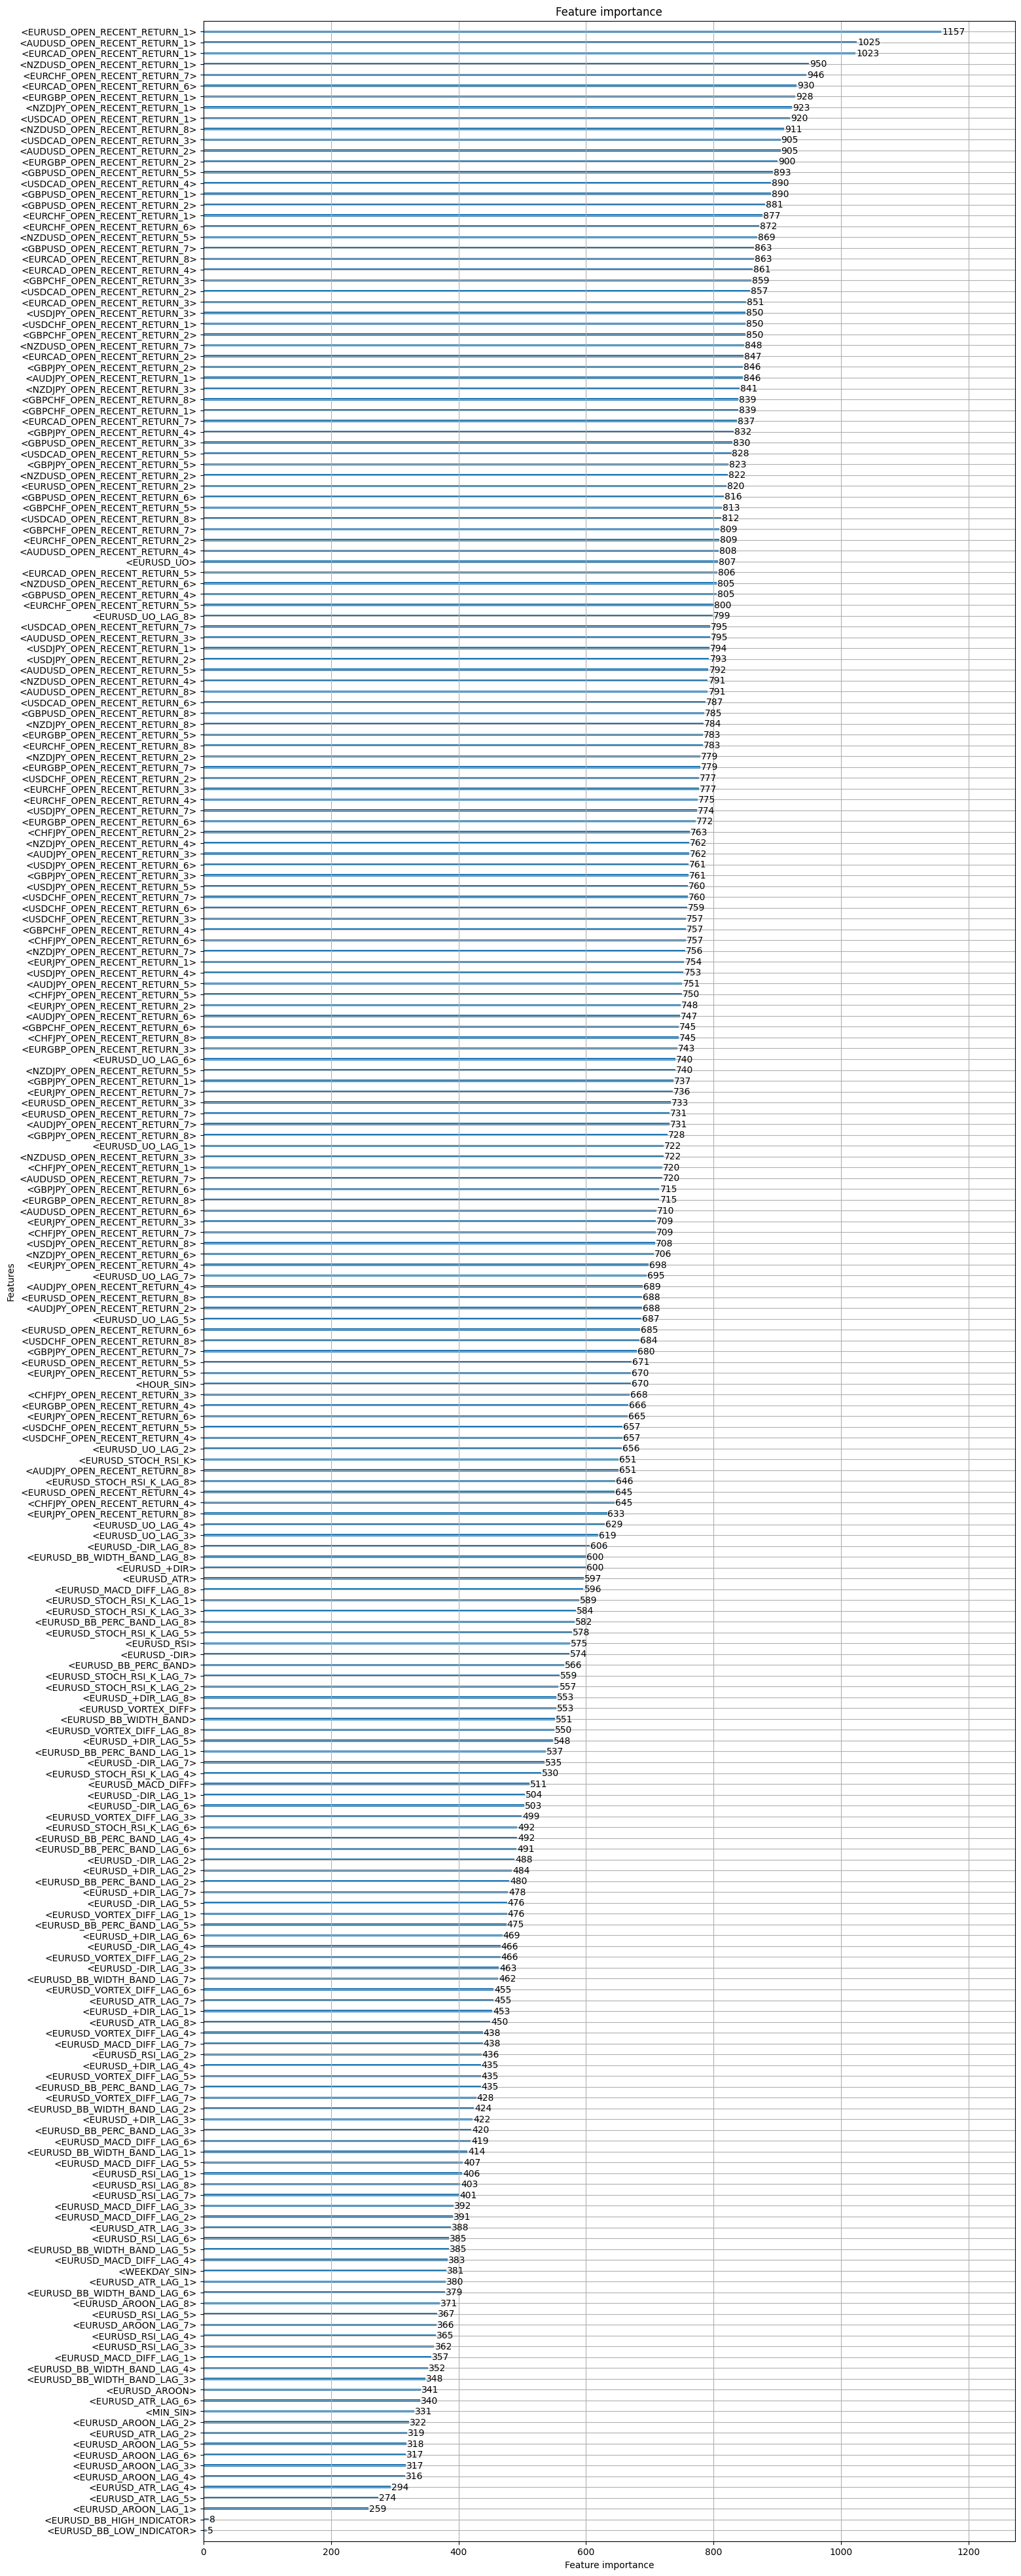

In [18]:
plt.rcParams["figure.figsize"] = (16,50)
plot_importance(lgbm_class)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [19]:
target_price_dir_pred_trn = lgbm_class.predict(extended_features_trn.drop('<DT>', axis=1))

In [20]:
metrics.accuracy_score(target_price_dir_trn, target_price_dir_pred_trn)

0.9533968277181629

In [21]:
target_price_dir_pred_val = lgbm_class.predict(extended_features_val.drop('<DT>', axis=1))

In [22]:
metrics.accuracy_score(target_price_dir_val, target_price_dir_pred_val)

0.6959

In [23]:
target_price_dir_pred_eval = lgbm_class.predict(extended_features_eval.drop('<DT>', axis=1))

In [24]:
metrics.accuracy_score(target_price_dir_eval, target_price_dir_pred_eval)

0.69052

Note that accuracy score can be misleading due to forward filling missing value imputation.

### Train set results

In [33]:
eurusd_trn_env = ForexEnvBasic(
    target_prices_trn,
    extended_features_trn.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001)
)

In [34]:
obs = eurusd_trn_env.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_trn_env.step(action)

100%|█████████████| 492325/492325 [02:20<00:00, 3508.87it/s]


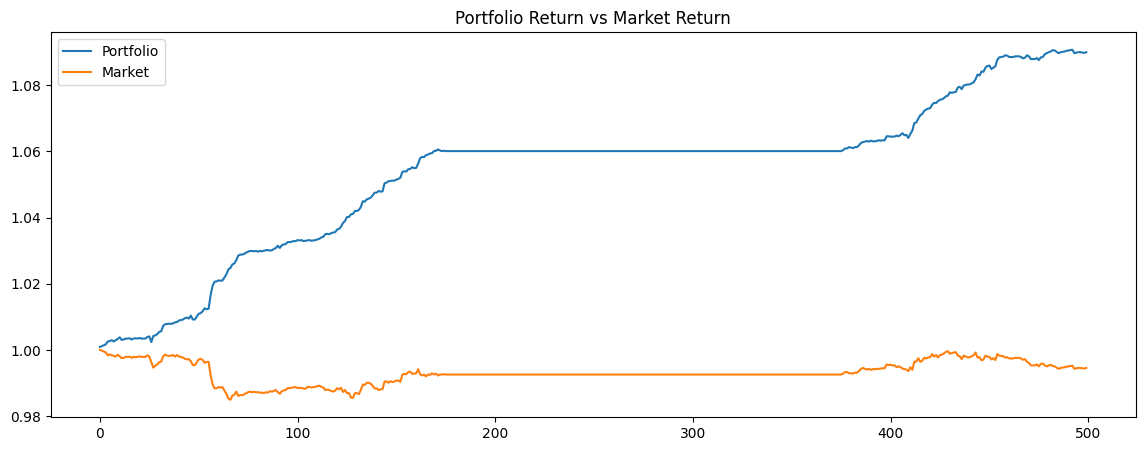

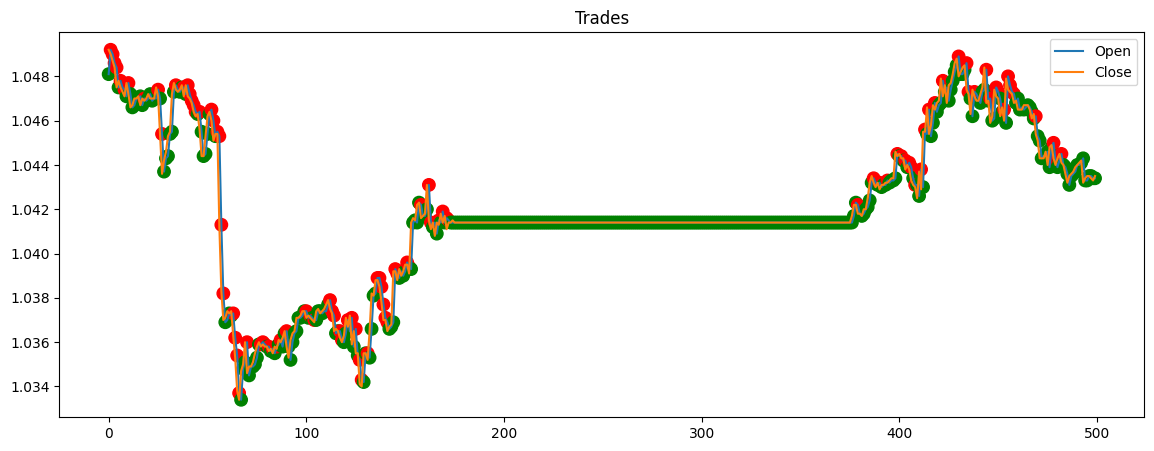

In [35]:
eurusd_trn_env.render(start_t=0, end_t=500)

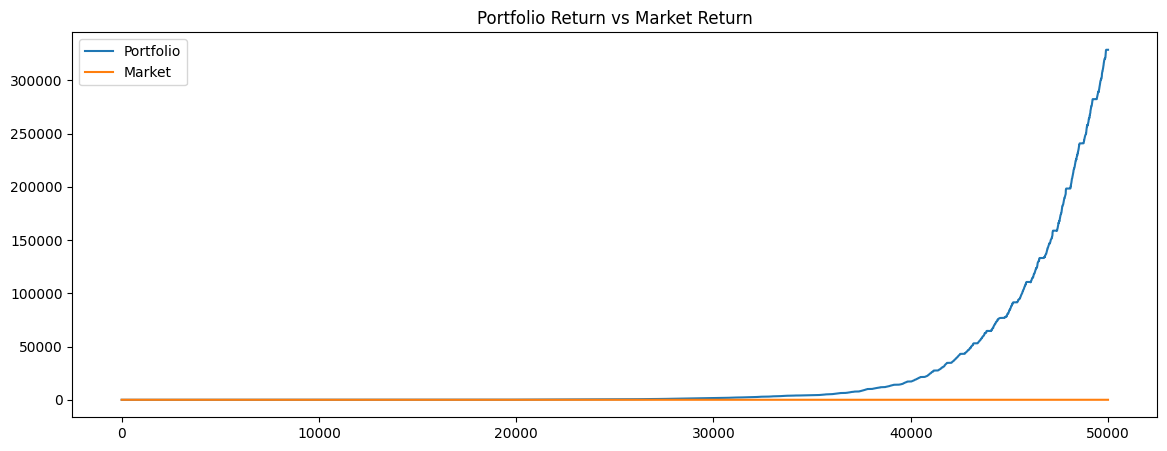

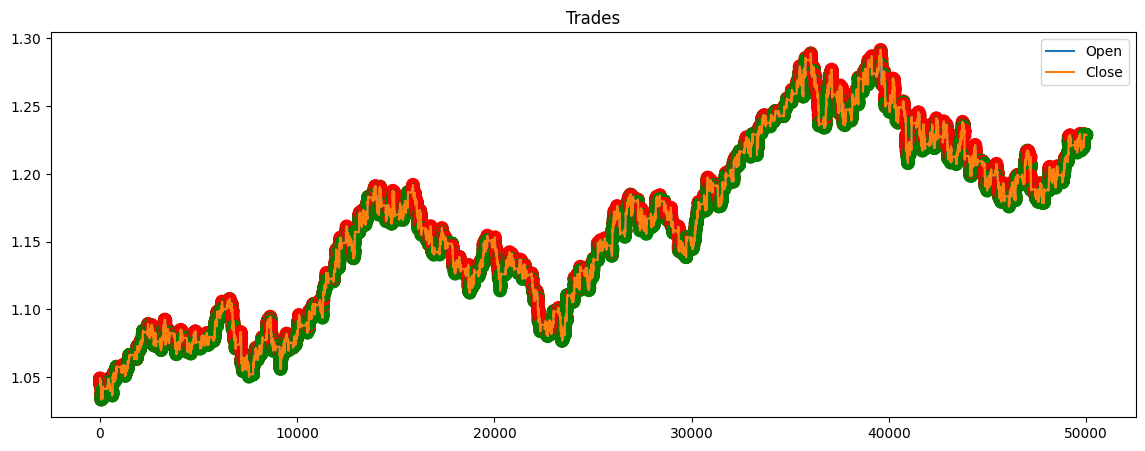

In [36]:
eurusd_trn_env.render(start_t=0, end_t=50000)

### Validation set results

#### No commission

In [16]:
eurusd_val_env = ForexEnvBasic(
    target_prices_val,
    extended_features_val.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0)
)

In [17]:
obs = eurusd_val_env.reset()
for i in tqdm(range(len(target_prices_val) - 10)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_val_env.step(action)

100%|███████████████| 99990/99990 [00:23<00:00, 4180.68it/s]


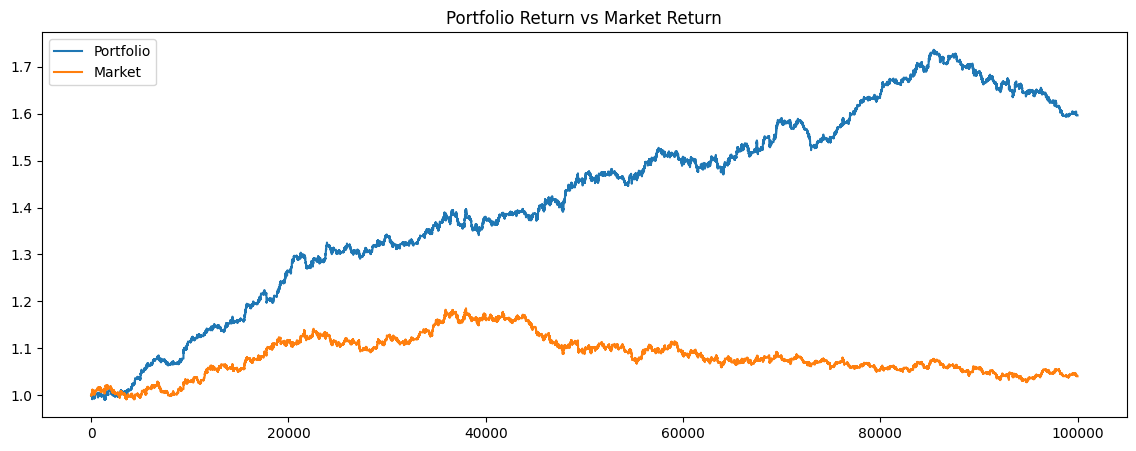

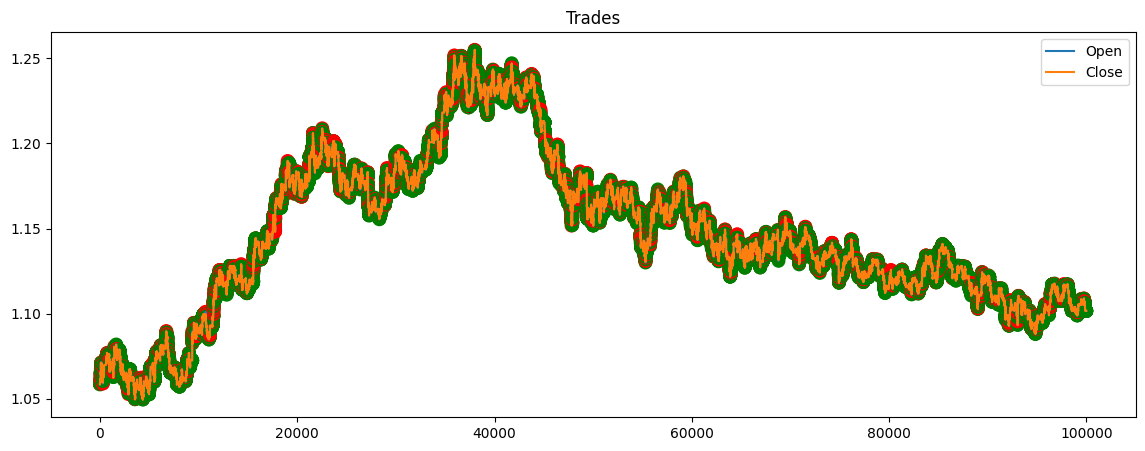

In [18]:
eurusd_val_env.render()

#### Small spread

In [20]:
eurusd_val_env = ForexEnvBasic(
    target_prices_val,
    extended_features_val.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001)
)

In [21]:
obs = eurusd_val_env.reset()
for i in tqdm(range(len(target_prices_val) - 10)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_val_env.step(action)

100%|███████████████| 99990/99990 [00:25<00:00, 3955.76it/s]


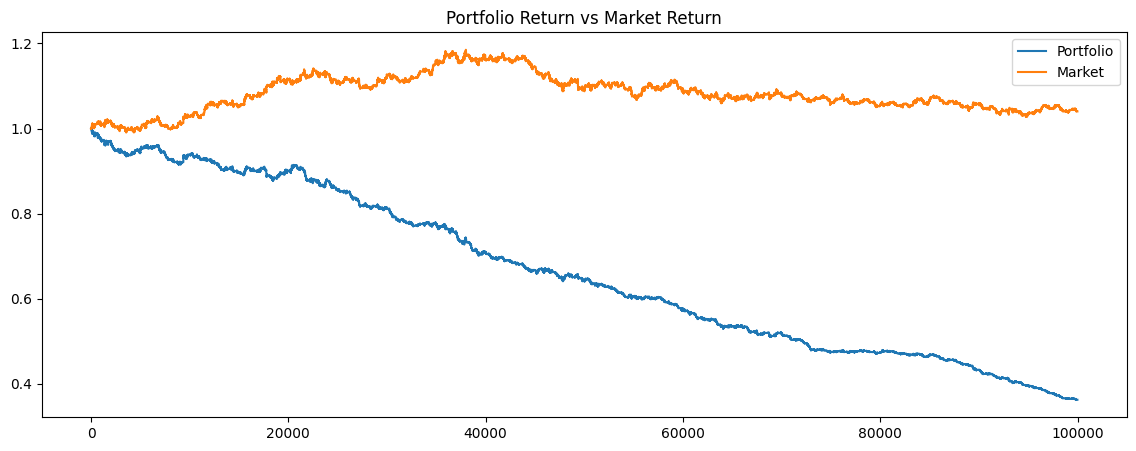

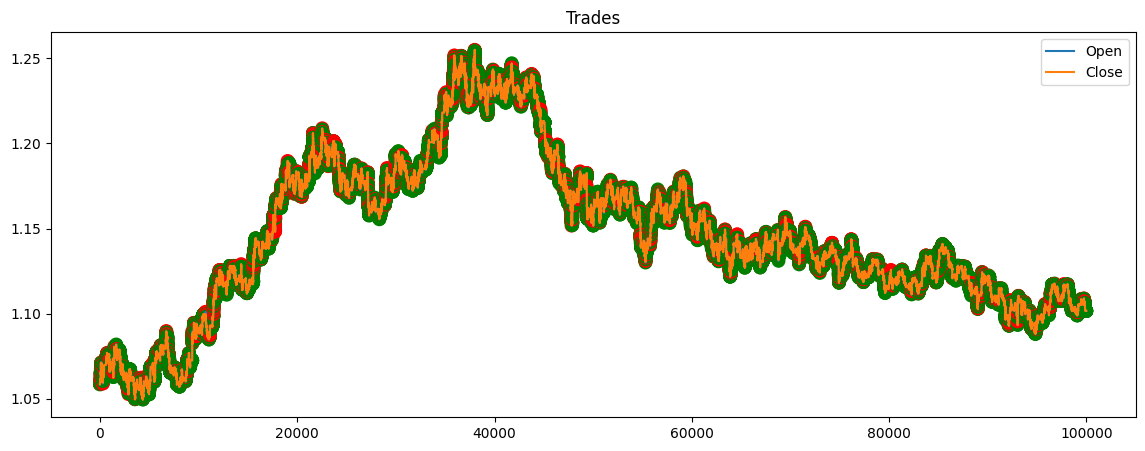

In [22]:
eurusd_val_env.render()

#### Small spread, fixed order size

In [39]:
eurusd_val_env = ForexEnvBasic(
    target_prices_val,
    extended_features_val.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyFixed(order_size=100),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001)
)

In [40]:
obs = eurusd_val_env.reset()
for i in tqdm(range(len(target_prices_val) - 10)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_val_env.step(action)

100%|█████████████████████████████████████████████████████████████| 99990/99990 [00:26<00:00, 3798.14it/s]


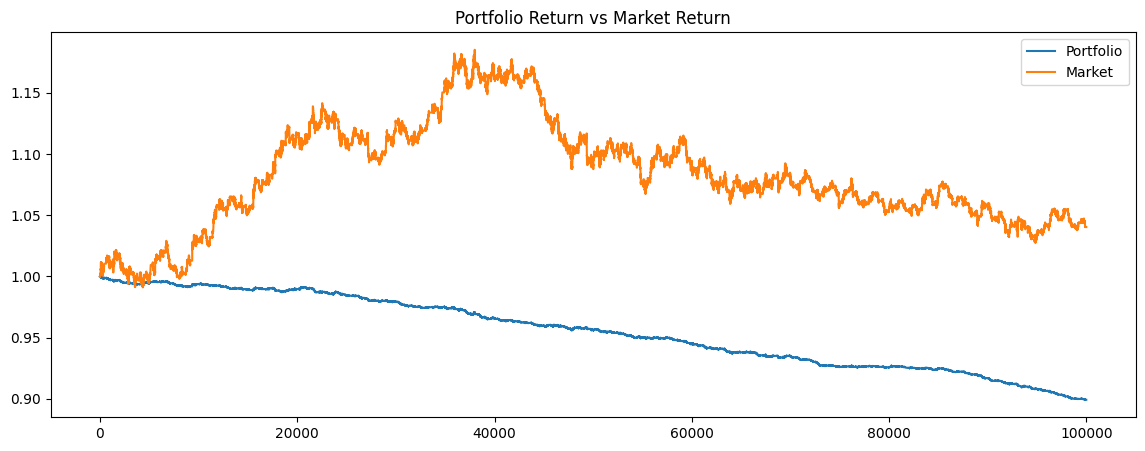

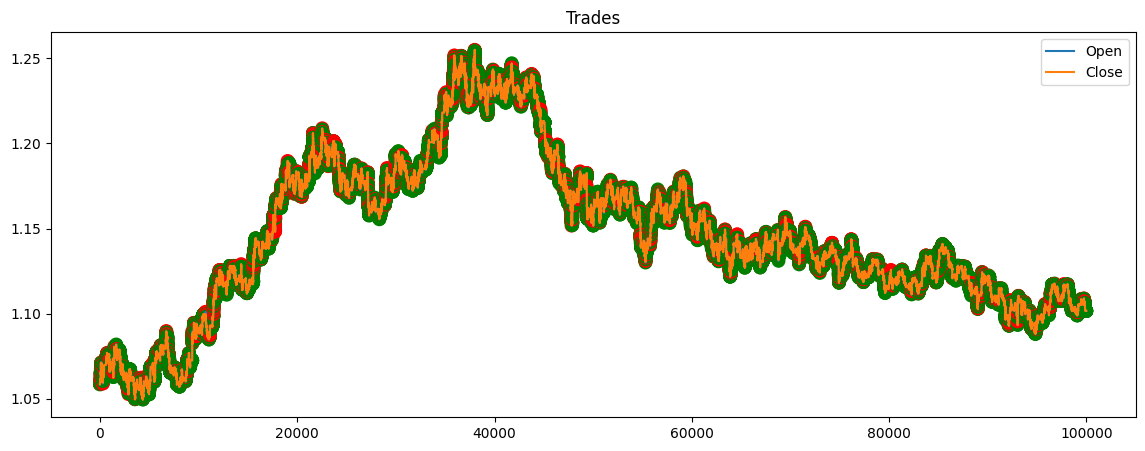

In [41]:
eurusd_val_env.render()

### Evaluation set results

#### No commission

In [23]:
eurusd_eval_env = ForexEnvBasic(
    target_prices_eval,
    extended_features_eval.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0)
)

In [24]:
obs = eurusd_eval_env.reset()
for i in tqdm(range(len(target_prices_eval) - 10)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_eval_env.step(action)

100%|███████████████| 99990/99990 [00:28<00:00, 3507.67it/s]


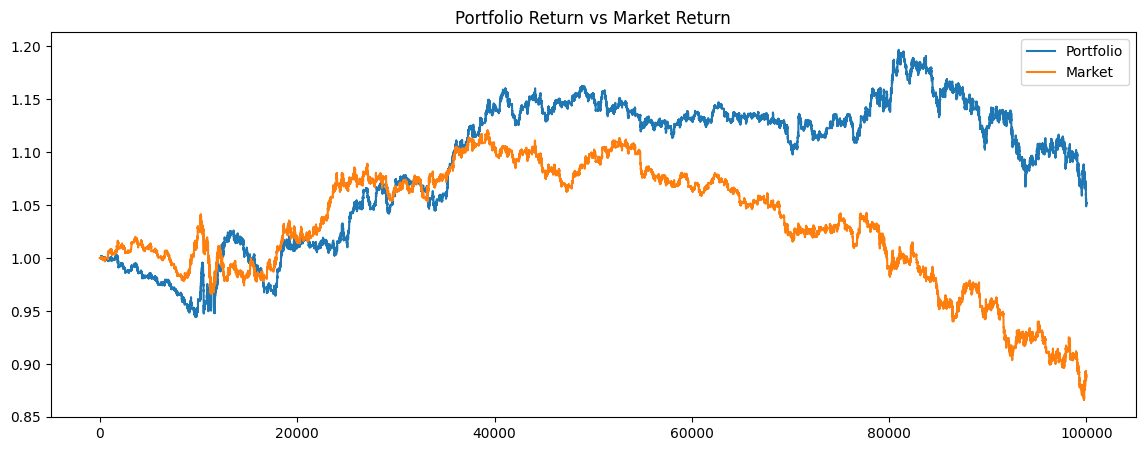

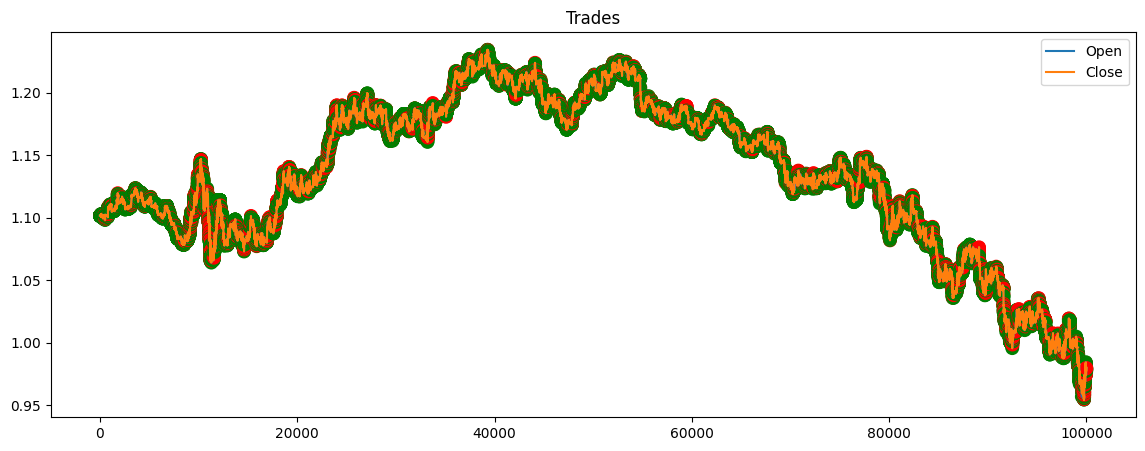

In [25]:
eurusd_eval_env.render()

#### Small spread

In [26]:
eurusd_eval_env = ForexEnvBasic(
    target_prices_eval,
    extended_features_eval.drop('<DT>', axis=1),
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001)
)

In [27]:
obs = eurusd_eval_env.reset()
for i in tqdm(range(len(target_prices_eval) - 10)):
    action = lgbm_class.predict(obs.reshape(1,-1))[0]
    obs, rewards, dones, info = eurusd_eval_env.step(action)

100%|███████████████| 99990/99990 [00:25<00:00, 3899.95it/s]


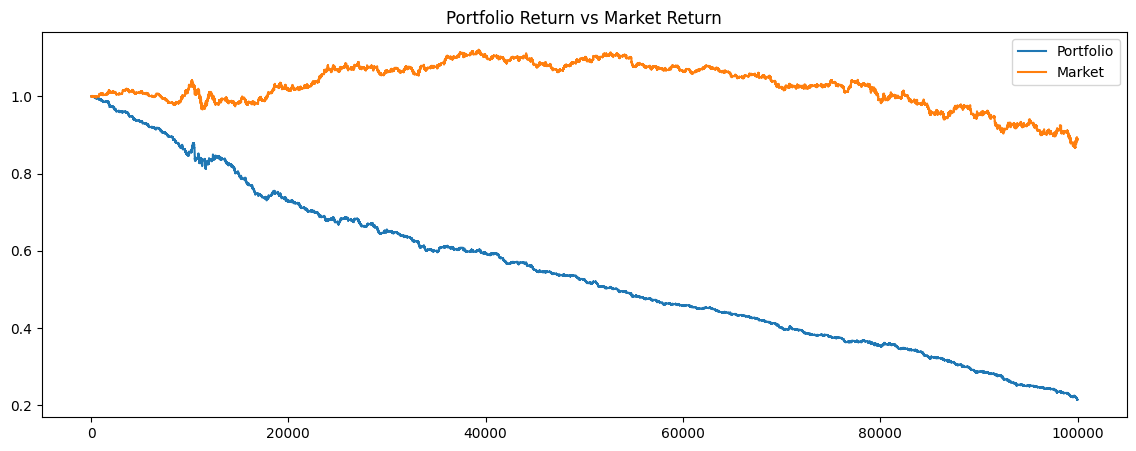

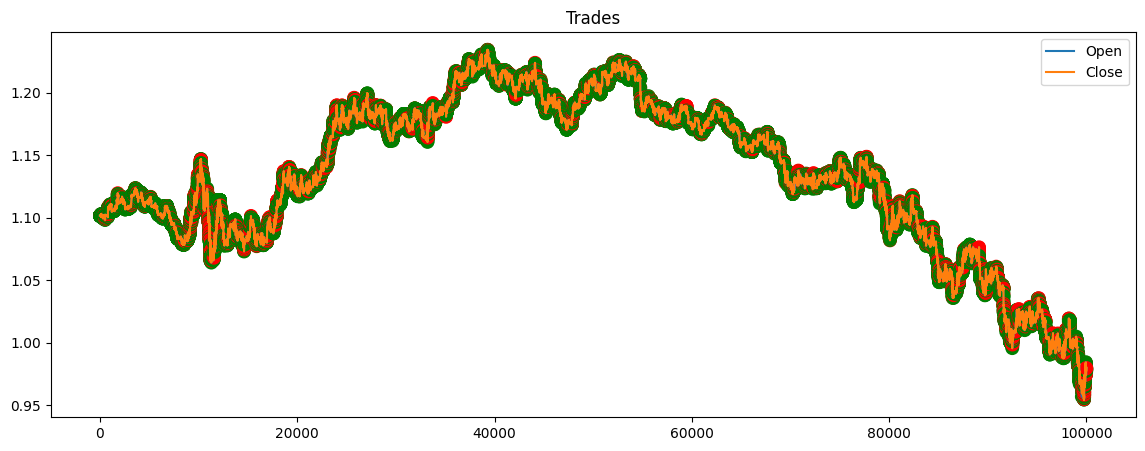

In [28]:
eurusd_eval_env.render()